# Deutsch and Deutsch-Josza algorithms

In [30]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.extensions import UnitaryGate
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_aer import *
import numpy as np


# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
# from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
# service = QiskitRuntimeService(channel="ibm_quantum")

## Defining a 1 bit XOR oracle

Defining the oracle

In [31]:
def ket(i):
    if i==0:
        return(np.matrix([[1],[0]]))
    else:
        return(np.matrix([[0],[1]]))
def bra(i):
    return(ket(i).H)
    
def Oracle(f):
    unitary = np.matrix([[0 for i in range(4)] for j in range(4)])
    for b in range(2):
        if f(b)==0:
            unitary += np.kron(np.matrix([[1,0],[0,1]]),ket(b) @ bra(b)) ## kron is the kronecker product, @ is the matrix product.
        else:
            unitary += np.kron(np.matrix([[0,1],[1,0]]),ket(b) @ bra(b))
    return(UnitaryGate(unitary,label='U_f'))
            

In [32]:
def f1(x):
    if x==0:
        return(1)
    else:
        return(0)

def f2(x):
    return(0)

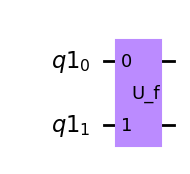

In [33]:
qr = QuantumRegister(2)
qc = QuantumCircuit(qr)

qc.append(Oracle(f1), qr)

qc.draw('mpl')

#Oracle(f2).to_matrix()

## Deutsch Algoritm

Create a quantum circuit implementing the Deutsch algorithm for a function $f\colon\{0,1\}\to\{0,1\}$ given as a parameter.

Create a function that runs the circuit a single time and answers if $f$ is constant or balanced.

In [37]:
def Deutsch_one_bit(O) :    
    x = QuantumRegister(1, "x")
    y = QuantumRegister(1, "y")
    res = ClassicalRegister(1, 'res')

    qc = QuantumCircuit(x, y)
    qc.add_register(res)

    qc.x(y)
    qc.h(x)
    qc.h(y)

    qc.append(O, [x, y])

    qc.h(x)

    qc.measure(x, res)

    # qc.draw('mpl')

    aer_sim = Aer.get_backend('aer_simulator')
    result = aer_sim.run(qc, shots=1, memory=True).result()
    measured_bit = int(result.get_memory()[0])
    
    if (measured_bit == 1):
        return "Balanced"  #measured 1 with 100% probability
    else:
        return "Constant"  #measured 0 with 100% probability
    


print("f1 is ", Deutsch_one_bit(Oracle(f1)))
print("f2 is ", Deutsch_one_bit(Oracle(f2)))
    

f1 is  Balanced
f2 is  Constant


## Deutsch-Josza algorithm

Generalize the XOR oracle generation for $n>=1$ and a function $f\colon\{0,1\}^n\to\{0,1\}$.

In [38]:
def ket_reg(n,x):
    if x < 0 or x > 2**n-1:
        return(-1)
    output = [[0] for i in range(x)]+[[1]]+ [[0] for i in range(2**n-x-1)]
    return(np.matrix(output))

In [39]:
def bra_reg(n,x):
    return(ket_reg(n,x).H)

In [40]:
ket_reg(3,3)

matrix([[0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0]])

In [41]:
np.kron(ket(0), np.kron(ket(1), ket(1)))

matrix([[0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0]])

In [42]:
bra_reg(4,5)

matrix([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [43]:
def Oracle(n,f):
    unitary = np.matrix([[0 for i in range(2**(n + 1))] for j in range(2**(n + 1))])
    for b in range(2 ** n):
        if f(b)==0:
            unitary += np.kron(np.matrix([[1,0],[0,1]]),ket_reg(n, b) @ bra_reg(n, b)) ## kron is the kronecker product, @ is the matrix product.
        else:
            unitary += np.kron(np.matrix([[0,1],[1,0]]),ket_reg(n, b) @ bra_reg(n, b))
    # print(unitary)
    return(UnitaryGate(unitary,label='U_f'))
    

In [44]:
def f3(x)->bool :
    return 1

def f4(x)->bool :
    return x%2

Implement the Deutsch-Josza algorithm

In [45]:
def Deutsch_Josza(n, O):
    qub = []
    qc = QuantumCircuit(0,0 )
    cr = ClassicalRegister(n, "res")
    qc.add_register(cr)
    
    for i in range(n):
        qi = QuantumRegister(1, i)
        qub.append(qi)
        qc.add_register(qub[i])
        qc.h(qub[i])
    
    minus = QuantumRegister(1, "-")
    qc.add_register(minus)
    qc.x(minus)
    qc.h(minus)
    qub.append(minus)
    
    qc.append(O, qub)
    
    
    for i in range(len(qub) - 1) :
        qc.h(qub[i])
        # qc.measure(qub[i], res)
        
    qc.measure(list(range(n)),cr)
        
    # qc.draw('mpl')
        
    aer_sim = Aer.get_backend('aer_simulator')
    result = aer_sim.run(qc, shots=1, memory=True).result()
    measured_bits = result.get_memory()
    
    if(measured_bits[0].find("1") != -1): #measured_bits[0] is the measured bitstring 
        return "Balanced"  #the bitstring with only 0s has been measured
    else:
        return "Constant"  #another random bitstring that contains at least a 1 has been measured




In [46]:
print("f3 is ", Deutsch_Josza(4, Oracle(4 ,f3)))
print("f4 is ", Deutsch_Josza(5 ,Oracle(5, f4)))

f3 is  Constant
f4 is  Balanced
